# Visualize User Behavior with RAPIDS TSNE and Item Matrix Factorization
In this notebook, we will use RAPIDS TSNE together with item embeddings from item matrix factorization (thank you [CPMP][1] and [Radek][2] for your notebooks) to visualize users' activity behavior.

In Kaggle's Otto Recommender System competition, the item ids are anonymized. So we do not know which each item id refers to. However, with item matrix factorization we can convert the anonymus item ids into meaningful embeddings. Then similar embeddings will be similar items. If we project the embeddings into the 2D plane (with TSNE, UMAP, PCA etc) and plot them, we can see clusters of similar items. Then one cluster may be clothing and another cluster could be electronics, etc etc.

Using the 2D plane of item embeddings, we can draw dots and lines showing the progression of each users' activity. This allows us to understand how users shop. Do users browse similar items, then view different items, then return to buy the original items. Do users mainly explore similar items? Or do users explore all sorts of items? The plots below will illuminate user behavior and help us understand the data and build better features and models!

**NOTE** The code for this notebook's item matrix factorization comes from CPMP's notebook [here][1] and Radek's notebook [here][2]. If you find my notebook helpful, please upvote their notebooks too!

Enjoy!

[1]: https://www.kaggle.com/code/cpmpml/matrix-factorization-with-gpu
[2]: https://www.kaggle.com/code/radek1/matrix-factorization-pytorch-merlin-dataloader

# Data Preprocessing
We will load and process data with RAPIDS cuDF

In [1]:
import cudf
import pickle
from cuml.neighbors import NearestNeighbors

print('RAPIDS cuDF version',cudf.__version__)

train = cudf.read_parquet('../input/otto-full-optimized-memory-footprint/train.parquet')
test = cudf.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')

train_pairs = cudf.concat([train, test])[['session', 'aid']]
del train, test

train_pairs['aid_next'] = train_pairs.groupby('session').aid.shift(-1)
train_pairs = train_pairs[['aid', 'aid_next']].dropna().reset_index(drop=True)

cardinality_aids = max(train_pairs['aid'].max(), train_pairs['aid_next'].max())
print('Cardinality of items is',cardinality_aids)

RAPIDS cuDF version 21.10.01
Cardinality of items is 1855602


# Install Merlin Dataloader!
We will feed our PyTorch model with Merlin dataloader!

In [2]:
!pip install merlin-dataloader==0.0.2
from merlin.loader.torch import Loader 

train_pairs.to_pandas().to_parquet('train_pairs.parquet') # TRAIN WITH ALL DATA
train_pairs[-10_000_000:].to_pandas().to_parquet('valid_pairs.parquet')

from merlin.loader.torch import Loader 
from merlin.io import Dataset

train_ds = Dataset('train_pairs.parquet')
train_dl_merlin = Loader(train_ds, 65536, True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 564.2 kB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Installing build dependencies ... - \ 

# Learn Item Embeddings with PyTorch Matrix Factorization Model
We will build a PyTorch model to generate item embeddings via matrix factorization.

In [3]:
import torch
from torch import nn

class MatrixFactorization(nn.Module):
    def __init__(self, n_aids, n_factors):
        super().__init__()
        self.aid_factors = nn.Embedding(n_aids, n_factors, sparse=True)
        
    def forward(self, aid1, aid2):
        aid1 = self.aid_factors(aid1)
        aid2 = self.aid_factors(aid2)
        
        return (aid1 * aid2).sum(dim=1)
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

valid_ds = Dataset('valid_pairs.parquet')
valid_dl_merlin = Loader(valid_ds, 65536, True)

In [4]:
from torch.optim import SparseAdam

num_epochs = 10
lr=0.1

model = MatrixFactorization(cardinality_aids+1, 32)
optimizer = SparseAdam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

model.to('cuda')
for epoch in range(num_epochs):
    for batch, _ in train_dl_merlin:
        model.train()
        losses = AverageMeter('Loss', ':.4e')
            
        aid1, aid2 = batch['aid'], batch['aid_next']
        aid1 = aid1.to('cuda')
        aid2 = aid2.to('cuda')
        output_pos = model(aid1, aid2)
        output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
        
        output = torch.cat([output_pos, output_neg])
        targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_pos)])
        loss = criterion(output, targets)
        losses.update(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    
    with torch.no_grad():
        accuracy = AverageMeter('accuracy')
        for batch, _ in valid_dl_merlin:
            aid1, aid2 = batch['aid'], batch['aid_next']
            output_pos = model(aid1, aid2)
            output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
            accuracy_batch = torch.cat([output_pos.sigmoid() > 0.5, output_neg.sigmoid() < 0.5]).float().mean()
            accuracy.update(accuracy_batch, aid1.shape[0])
            
    print(f'{epoch+1:02d}: * TrainLoss {losses.avg:.3f}  * Accuracy {accuracy.avg:.3f}')

01: * TrainLoss 0.597  * Accuracy 0.721
02: * TrainLoss 0.596  * Accuracy 0.726
03: * TrainLoss 0.591  * Accuracy 0.728
04: * TrainLoss 0.593  * Accuracy 0.729
05: * TrainLoss 0.592  * Accuracy 0.730
06: * TrainLoss 0.587  * Accuracy 0.730
07: * TrainLoss 0.589  * Accuracy 0.730
08: * TrainLoss 0.588  * Accuracy 0.731
09: * TrainLoss 0.587  * Accuracy 0.731
10: * TrainLoss 0.588  * Accuracy 0.731


# Extract Item Embeddings
We extract item embeddings from our model's embedding table.

In [5]:
# EXTRACT EMBEDDINGS FROM MODEL EMBEDDING TABLE
embeddings = model.aid_factors.weight.detach().cpu().numpy()
print('Item Matrix Factorization embeddings have shape',embeddings.shape)

Item Matrix Factorization embeddings have shape (1855603, 32)


In [6]:
with open("real_embeddings.pickle", mode="wb") as f:
    pickle.dump(embeddings, f)

# Visualize User Behavior with RAPIDS TSNE
We will use RAPIDS cuML's TSNE to reduce embedding dimension to 2 dimensions so we can plot in x-y-plane.

In [7]:
# IMPORT RAPIDS TSNE
from cuml import UMAP, TSNE, PCA
import matplotlib.pyplot as plt, numpy as np
import matplotlib.patches as mpatches, cuml
print('RAPIDS cuML version',cuml.__version__)

# FIT TRANSFORM TSNE
em_2d = TSNE(n_components=2, random_state = 224).fit_transform(embeddings)
print('TSNE embeddings have shape',em_2d.shape)

RAPIDS cuML version 21.10.02
[W] [01:09:05.170437] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
TSNE embeddings have shape (1855603, 2)


In [8]:
with open("2d_embeddings.pickle", mode="wb") as f:
    pickle.dump(em_2d, f)

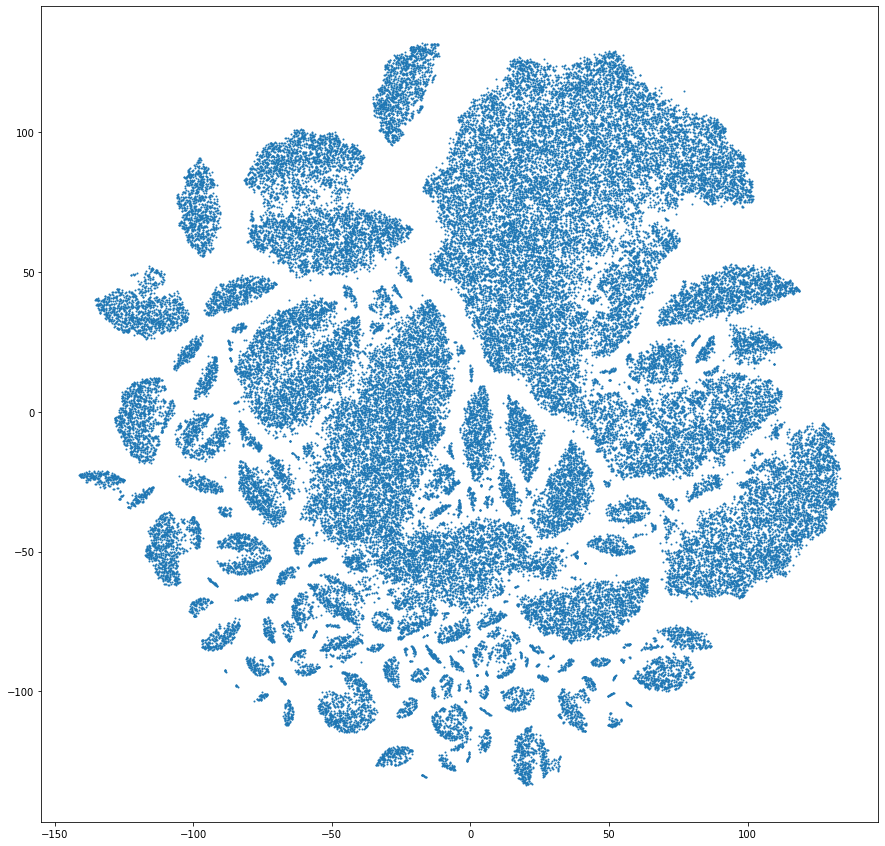

In [9]:
plt.figure(figsize=(15,15))
plt.scatter(em_2d[::25,0],em_2d[::25,1],s=1,label='All 1.8M items!')

100%|██████████| 99/99 [06:54<00:00,  4.19s/it]


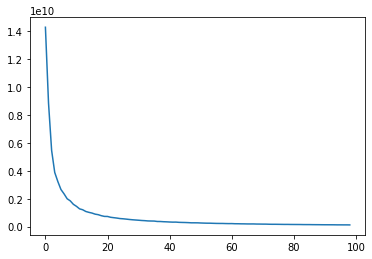

In [10]:
from cuml.cluster import KMeans
from tqdm import tqdm

values = []
for i in tqdm(range(1, 100)):
    knn = KMeans(n_clusters=i, random_state=224)
    knn.fit(em_2d)
    values.append(knn.inertia_)

plt.plot(np.arange(len(values)), values)

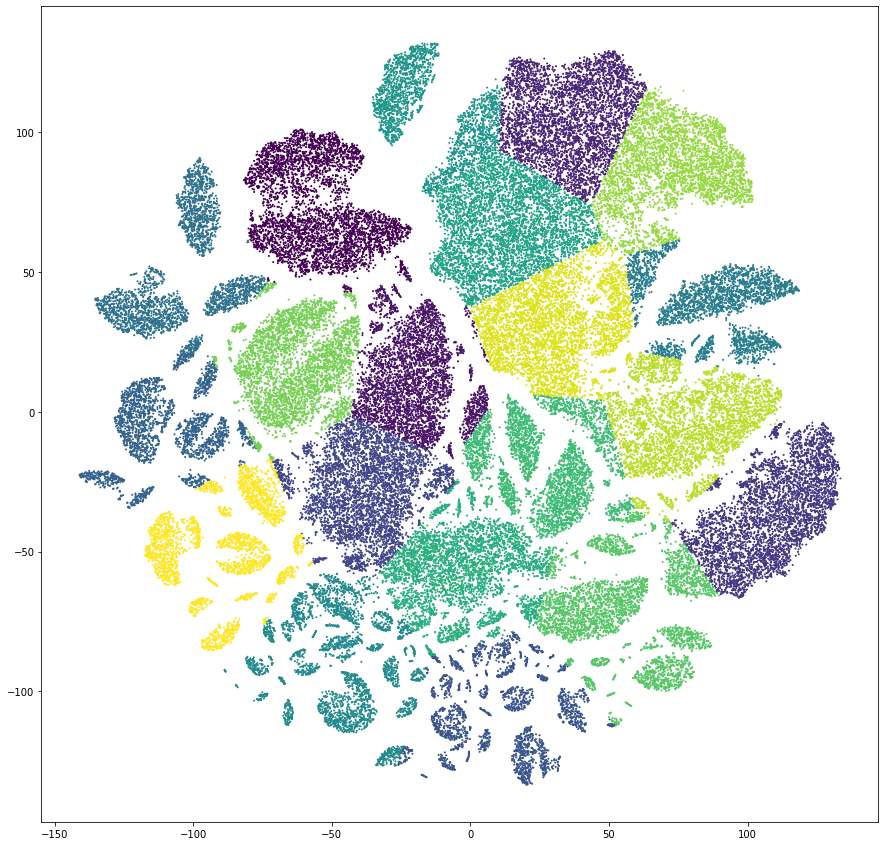

In [11]:
knn = KMeans(n_clusters=20, random_state=224)
knn.fit(em_2d)
plt.figure(figsize=(15,15))
plt.scatter(em_2d[::25,0],em_2d[::25,1], c = knn.labels_[::25], s=1,label='All 1.8M items!')

In [12]:
with open("2d_embeddings_class.pickle", mode="wb") as f:
    pickle.dump(knn.labels_, f)

# LOAD TEST DATA
test = cudf.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')
tmp = test.groupby('session').aid.agg('count').rename('n')
test = test.merge(tmp, left_on='session', right_index=True, how='left')
active_users = test.loc[test.n>20,'session'].unique().to_array()
test = test.sort_values(['session','ts'])
print('Test data shape:', test.shape )
test.head()

# Display User Activity with TSNE Item Embeddings
For 50 random users (who have 20 or more activity), we will plot their activity over time. The top plots show the category of items interacted with and the bottom plot show the times of item interaction. When dots are close to each other in the top plot, then the items are similar. For example, two items of clothing will be close while an item of clothing will be far from an item of electronics.

The numbers in the plot are sorted by time. Number 1 is the first item a user interactied with while number 10 is the 10th item etc. We only display some numbers so that the numbers are readable. Orange dots are clicks, green dots are carts, and red dots are buys. The 1.8 million blue dots are all unique items. We observe clusters of blue dots which represent different categories of items.

The x-y-plane indicates different item categories. If users stay in the same area then they are shopping similar items like clothing department. When a user's plot changes from one region of x-y-plane to another, then the user changes to a different category of item like moving from clothing shopping to electronics shopping. We observe different types of users. Some users explore one category of item while other users explore a variety of item categories.

# DISPLAY EDA FOR 50 USERS
for k in range(50):
    
    # SELECT ONE USER WITH 20+ CLICKS
    u = np.random.choice(active_users)
    dff = test.loc[test.session==u].to_pandas().reset_index(drop=True)
    tmp = dff.aid.values
    clicks = test.loc[(test.session==u)&(test['type']==0)].to_pandas().aid.values
    carts = test.loc[(test.session==u)&(test['type']==1)].to_pandas().aid.values
    orders = test.loc[(test.session==u)&(test['type']==2)].to_pandas().aid.values

    ############
    ## PLOT HISTORY BY ITEM CATEGORY
    ############
    
    # PLOT CLICKS, CARTS, ORDERS OVER TSNE ITEM EMBEDDING PLOT
    plt.figure(figsize=(15,15))
    plt.scatter(em_2d[::25,0],em_2d[::25,1],s=1,label='All 1.8M items!')
    plt.plot(em_2d[tmp][:,0],em_2d[tmp][:,1],'-',color='orange')
    plt.scatter(em_2d[tmp][:,0],em_2d[tmp][:,1],color='orange',s=25,label='Click')
    plt.scatter(em_2d[carts][:,0],em_2d[carts][:,1],color='green',s=100,label='Cart')
    plt.scatter(em_2d[orders][:,0],em_2d[orders][:,1],color='red',s=250,label='Order')
    
    # PLOT NUMBERS OF ORDER VISITED
    old_xy = []; pos = []
    for i,(x,y) in enumerate(zip(em_2d[tmp][:,0],em_2d[tmp][:,1])):
        new_location = True
        for j in old_xy:
            if (np.abs(x-j[0])<5) & (np.abs(y-j[1])<5):
                new_location = False
        if new_location:
            plt.text(x,y,f'{i+1}',size=18)
            old_xy.append( (x,y) ); pos.append(i)
            
    # LABEL PLOT
    plt.legend()
    plt.title(f'Test User {u} - {len(clicks)} clicks, {len(carts)} carts, {len(orders)} orders:',size=18)
    #plt.xlabel('Item category',size=16)
    plt.ylabel('\n\nItem category',size=16)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()
    
    ############
    ## PLOT HISTORY BY DAY AND HOUR
    ############
    
    mn = test.ts.min()
    dff['day'] = (dff.ts - mn) // (60*60*24)
    dff['hour'] = ((dff.ts - mn) % (60*60*24)) // (60*60)
    
    plt.figure(figsize=(15,3))
    xx = np.random.uniform(-0.2,0.2,len(dff))
    yy = np.random.uniform(-0.5,0.5,len(dff))
    plt.scatter(dff.day.values+xx, dff.hour.values+yy, s=25, color='orange')
    cidx = dff.loc[dff['type']==1].index.values
    oidx = dff.loc[dff['type']==2].index.values
    plt.scatter(dff.day.values[cidx]+xx[cidx], dff.hour.values[cidx]+yy[cidx], s=50, color='green')
    plt.scatter(dff.day.values[oidx]+xx[oidx], dff.hour.values[oidx]+yy[oidx], s=100, color='red')
    old_xy = []
    for i in range(len(dff)):
        if 1: #i in pos:
            x = dff.day.values[i]+xx[i]
            y = dff.hour.values[i]+yy[i]
            new_location = True
            for j in old_xy:
                if (np.abs(x-j[0])<0.5) & (np.abs(y-j[1])<4):
                    new_location = False
            if new_location:
                plt.text(x, y, f'{i+1}', size=18)
                old_xy.append( (x,y) )
    plt.ylim((-1,25))
    plt.xlim((-1,7))
    plt.ylabel('Hour of Day',size=16)
    plt.xlabel('Day of Month',size=16)
    plt.yticks([0,4,8,12,16,20,24],['12am','4am','8am','noon','4pm','8pm','12am'])
    plt.xticks([0,1,2,3,4,5,6],['Mon\nAug 29th','Tue\nAug 30rd','Wed\nAug 31st',
                            'Thr\nSep 1st','Fri\nSep 2nd','Sat\nSep 3rd','Sun\nSep 4th'])
    c1 = mpatches.Patch(color='orange', label='Click')
    c2 = mpatches.Patch(color='green', label='Cart')
    c3 = mpatches.Patch(color='red', label='Order')
    plt.legend(handles=[c1,c2,c3])
    plt.show()
    
    print('\n\n\n\n\n\n\n')